# **Data analysis on Covid-19 in Thailand by Machine Learning**


> Team member: 
*   Menghorng Bun (6222040096)
*   Ming Hsien Chuang (6214552743)
*   Nyan Lin Htet (6222040351)










# Problem understanding
* Forecasting different scenarios on the spread of COVID-19 in Thailand. (aim)
* Main Challenge - estimating model parameters
* Differential equations of the well-established SIR(Susceptible-Infected-Recovered) model.
* Parameter estimation - Monte Carlo importance sampling on the model parameters - distribution of parameters that well describes the observed data
* Forecast - evolving the model equations with parameter samples from the distribution


In [0]:
# install and load libraries
!pip install --upgrade --quiet gspread 
!pip install --quiet sklearn
!pip install --quiet seaborn
!pip install pymc3
!pip install pandas
!pip install numpy
!pip install statsmodels
!pip install --user tensorflow
!pip install --user keras

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#-------------------------------------------------------------------------------
# Step1 : Data generation or data loading
#-------------------------------------------------------------------------------
#get confirm case 
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
#get death case
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = ''
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Burma,21.9162,95.9560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8
249,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
250,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
251,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


# SIR (Susceptible-Infected-Recovered) Model
We consider a discrete SIR (Susceptible-Infected-Recovered) model. In short, we assume that the disease spreads at rate $λ$ from an infected person $(I)$ to a susceptible person $(S)$ and that an infected person becomes a recovered person $(R)$ at rate $μ$, i.e.

$S+I→^λ I+I$

$I →^μ R$.

This well-established model for disease spreading can be described by the following set of (deterministic) ordinary differential equations [see, e.g., Wikipedia or recent works on the spread of covid-19]. Within a population of size $N$,

$dS/dt=−λSI/N$

$dI/dt=λSI/N − μI $

$dR/dt=μI$.

Because our data set is discrete in time ($Δt$=1 day), we solve the above differential equations with a discrete time step ($dI/dt≈ΔI/Δt$), such that

$S_t−S_{t−1}=−λΔtS_t/NI_{t−1}=:−I^{new}_t$

$R_t−R_t−1=μΔtI_{t−1}=:R^{new}_t$

$I_t−I_{t−1}=(λS_{t-1}/N−μ)ΔtI_{t−1}=I^{new}_t−R^{new}_t$.


Importantly, $I_t$ models the number of all active, (currently) infected people, while $I^{new}_t$ is the number of new infections that is reported according to standard WHO convention. Furthermore, we explicitely include a reporting delay $D$ between new infections $I^{new}_t$ and reported cases when generating the forecast.


# Exponential growth during outbreak onset

Note that in the onset phase, only a tiny fraction of the population is infected $(I)$ or recovered $(R)$, and thus $S≈N≫I$ such that $S/N≈1$. Therefore, the differential equation for the infected reduces to a simple linear equation, exhibiting an exponential growth

$dI/dt=(λ−μ)I$ solved by $I(t)=I(0) e^{(λ−μ)t}$.

# Estimating model parameters

We estimate the set of model parameters $θ$={$λ,μ,σ,I0$} using Bayesian inference with Markov-chain Monte-Carlo (MCMC). Our implementation relies on the python package pymc3 with NUTS (No-U-Turn Sampling).

The structure of our approach is the following:

* **Choose random initial parameters and evolve according to model equations**. Initially, we choose paramters θ from prior distributions that we explicitly specify below. Then, time integration of the model equations generates a (fully deterministic) time series of new infected cases $I^{new}(θ)$={$I^{new}_t(θ)$} of the same length as the observed real-world data $I^{new}$={$I^{new}_t$}.

* **Recursively update the parameters using MCMC**. The drawing of new candidate parameters and the time integration is repeated in every MCMC step. The idea is to propose new parameters and to accept them in a way that overall reduces the deviation between the model outcome and the real-world data. We quantify the deviation between the model outcome Inewt(θ) and the real-world data I^newt for each step t of the time series with the local likelihood

  $p(I^{new}_t ∣θ)∼StudentTν=4(mean=I^{new}_t(θ),width=σ\sqrt{I^{new}_t(θ)})$

  We chose the Student’s t-distribution because it approaches a Gaussian distribution but features heavy tails, which make the MCMC more robust with respect to outliers [Lange et al, J. Am. Stat. Assoc, 1989]. The square-root width models the demographic noise of typical mean-field solutions for epidemic spreading [see, e.g., di Santo et al. (2017)].

  For each MCMC step, the new parameters are drawn so that a set of parameters that minimizes the previous deviation is more likely to be chosen. In our case, this is done with an advanced gradient-based method (NUTS). Every time integration that is performed (with its own set of parameters) yields one Monte Carlo sample, and the MCMC step is repeated to create the full set of samples. Eventually, the majority of sampled parameters will describe the real-world data well, so that consistent forecasts are possible in the forecast phase.

* **Forecast using Monte Carlo samples**. For the forecast, we take all samples from the MCMC step and continue time integration according to different forecast scenarios explained below. Note that the overall procedure yields an ensemble of predictions — as opposed to a single prediction that would be solely based on one set of (previously optimized) parameters.

In [0]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time
#-------------------------------------------------------------------------------
# Step 2: Prepare data that we want to train
#-------------------------------------------------------------------------------
#select data to train the model
data_end   = '3/24/20' #Take the data until yesterday
data_begin = '3/1/20' 
num_days_to_predict = 31 #prediction date
#select confirm case data from data begin to data end
cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Thailand", data_begin:data_end])[0]
date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == "Thailand", data_begin:data_end].columns[-1]
#formate date
month, day, year = map(int,date_data_end.split('/')) 
date_data_end = datetime.date(year+2000, month, day)
date_today = date_data_end + datetime.timedelta(days=1)
print('Cases yesterday ({}): {} and day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = len(cases_obs)
# makes the random numbers predictable
np.random.seed(0)

# ------------------------------------------------------------------------------ #
# Step 3: model setup and training
# ------------------------------------------------------------------------------ #
#-------------------------------------------------------------------------------
# Step 3.1. write Fuction of SIR Model with population
#-------------------------------------------------------------------------------
# λ is spreading rate, μ is recovery rate
# S_begin is susceptible at time 0, I_begin is the infacted at time 0, N is population
# S_t is susceptible at time t, I_t is the infacted at time t
# new_I_t is new infacted at time t
def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin) 
    def next_day(λ, S_t, I_t, _):
        new_I_t = (λ/N)*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all
#-------------------------------------------------------------------------------
# Step 3.2. Estimating Model parameters 
#-------------------------------------------------------------------------------
with pm.Model() as model:
    #-----------------------------------------------------------------------------
    # Step 3.2.1: theta is the set of estimation parameters {λ, μ, σ_obs, I_begin}
    #-----------------------------------------------------------------------------
    # true cases at begin of loaded data but we do not know the real number (sigma is 90%)
    I_begin = pm.Lognormal("I_begin", mu=np.log(cases_obs[0]), sigma=0.9)

    # fraction of people that are newly infected each day (sigma is 50%)
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu (sigma is 20%)
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=1)

    N_thailand =69.8e6 #Thailand population in 2020

    # -------------------------------------------------------------------------- #
    # Step 3.2.2 training the model with loaded data
    # -------------------------------------------------------------------------- #
    # Initail state
    S_begin = N_thailand - I_begin
    #calculate S_past, I_past, new_I_past usign sir model
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_thailand)
    new_infections_obs = np.diff(cases_obs)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    #Recursively update the parameters using MCMC
    #syntax of pymc3=> https://docs.pymc.io/api/distributions/continuous.html
    pm.StudentT( #Student’s T log-likelihood eg: pm.StudentT(nu[, mu, lam, sigma, sd])
        "obs",
        nu=4,
        mu=new_I_past,
        sigma=new_I_past ** 0.5 * σ_obs,
        observed=new_infections_obs
        )  
    #saves the variables for later retrieval
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)

    # -------------------------------------------------------------------------- #
    # Step 3.2.3 prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #
    
    # delay in days between contracting the disease and being recorded
    # assuming a median delay of 8 days.
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.1)#
    # Initail state
    S_begin = S_past[-1]
    I_begin = I_past[-1]
    #Forecast in no change condition
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_thailand)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    # -------------------------------------------------------------------------- #
    # Step 3.2.4 social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days

    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this
    #time arangement 
    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - delay - days_offset + 1) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 
    # Initail state
    S_begin = S_past[-1]
    I_begin = I_past[-1]
    #Forecast in social distancing
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_thailand)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    #saves the variables for later retrieval
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    # -------------------------------------------------------------------------- #
    # Step 3.2.5 isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)
    # Initail state
    S_begin = S_past[-1]
    I_begin = I_past[-1]
    #Forecast in Strong social distancing
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_thailand)
    S_isol, I_isol, new_I_isol = forecast_isol
    #saves the variables for later retrieval
    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    # -------------------------------------------------------------------------- #
    # Step 3.2.6 isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 
    # Initail state
    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    #Forecast in strong social distancing at 5 days later
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_thailand)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later
    #saves the variables for later retrieval
    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)


    # -------------------------------------------------------------------------- #
    # Step 3.2.7 isolation 7 days earlyier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #
    
    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - delay - days_offset+1) / length_transient, 0, 1)
    λ_t_isol_earlyier= λ * (1 - λ_correction * reduc_factor_strong) 
    # Initail state
    S_begin = S_past[-1]
    I_S_begin = I_past[-1]
    #Forecast in storng social distancing at 7 days earlyier 
    forecast_isol_earlyier = SIR_model(λ=λ_t_isol_earlyier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_thailand)
    S_isol_earlyier, I_isol_earlyier, new_I_isol_earlyier = forecast_isol_earlyier
    #saves the variables for later retrieval
    pm.Deterministic('S_isol_earlyier', S_isol_earlyier)
    pm.Deterministic('I_isol_earlyier', I_isol_earlyier)  
    pm.Deterministic('new_I_isol_earlyier', new_I_isol_earlyier)

    # -------------------------------------------------------------------------- #
    # Step 3.2.8 run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    time_beg = time.time()
    trace = pm.sample(draws=500, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-03-24): 827 and day before yesterday: 721


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [delay, σ_obs, μ, λ, I_begin]
100%|██████████| 1300/1300 [00:31<00:00, 40.86it/s]


Model run in 138.14 s


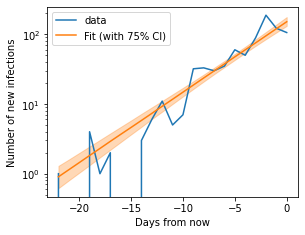

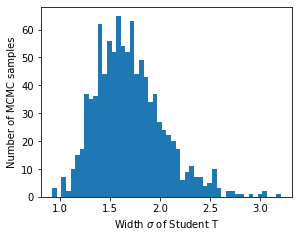

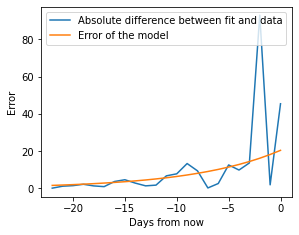

In [0]:
#-------------------------------------------------------------------------------
# Step 4 plotting data 
#-------------------------------------------------------------------------------
#time arangement
time = np.arange(-len(cases_obs)+2, 1)
#Compute the q-th percentile of the data along the specified axis
percentiles = np.percentile(trace.new_I_past, q=12.5, axis=0), np.percentile(trace.new_I_past, q=87.5, axis=0)
#fit data with 75% CI
fit_75ci=np.median(trace.new_I_past, axis=0)
#Error = σ*(Inew)^(1/2)
Error = np.sqrt(np.median(trace.new_I_past, axis=0))*np.median(trace.σ_obs, axis=0)
#Absolute difference between fit and data
fit_data = np.abs(np.median(trace.new_I_past, axis=0) - np.diff(cases_obs))
#-------------------------------------------------------------------------------
# Step 4.1 plotting data of new infections
#-------------------------------------------------------------------------------
plt.figure(figsize=(4.5,3.5))
plt.plot(time, np.diff(cases_obs), label='data')#plot data load
plt.plot(time,fit_75ci ,color='tab:orange', label='Fit (with 75% CI)')
plt.fill_between(time, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
plt.yscale('log')
plt.ylabel('Number of new infections')
plt.xlabel('Days from now')
plt.legend()
plt.savefig('Number of new infections.png', dpi=200)

#print(trace.new_I_past[-1])
#print(trace.new_I_isol[-1])
#print(trace.new_I_no_change[-1])
#-------------------------------------------------------------------------------
# Step 4.2 plotting data of MCMC samples(σ_obs)
#-------------------------------------------------------------------------------
plt.figure(figsize=(4.5,3.5))
plt.hist(trace.σ_obs, bins=50)
plt.ylabel('Number of MCMC samples')
plt.xlabel('Width $\sigma$ of Student T')
plt.savefig('Number of MCMC samples.png', dpi=200)
#-------------------------------------------------------------------------------
#Step 4.3 plotting data of Error
#-------------------------------------------------------------------------------
plt.figure(figsize=(4.5,3.5))
plt.plot(time,fit_data , label='Absolute difference between fit and data')
plt.plot(time, Error , label='Error of the model')
plt.ylabel('Error')
plt.xlabel('Days from now')
plt.legend(loc='upper left')
plt.savefig('error.png', dpi=200)

# Constraining parameters

The available real-world data is not informative enough to fit all free parameters, or to empirically find the underlying distributions. We set the following informative priors on the initial model rates:

The spreading rate is set to **λ∼LogNormal(log(0.4),0.5)**, where 0.4 is an initial guess that corresponds to 40% new infections day over day.


The recovery rate is set to **μ∼LogNormal(log(1/8),0.2)**, which corresponds to median recovery time of 8 days.


The remaining model parameters are constrained by uninformative priors, in practice the Half-Cauchy distribution [Gelman, Bayesian Anal., 2006]:


**σ∼HalfCauchy(1)** — The scale factor of the width of the Student’s t-distribution of new cases.


**I0∼LogNormal(log(I^0),0.9)** — The number of infected people in the model (I0) is constrained to be distributed around the recorded number of infected people (I^0) on the day before the first data point we fit.


The MCMC sampler finds the posterior distribution p(θ|I^new) of model parameters θ such that the model equations match the real-world data. As an example, below we plot the effective spread (λ−μ, which corresponds to the daily rate of case increase) inferred from the data of the past.

![alt text](https://drive.google.com/uc?id=1Hh226aypoL4ra6wJl2OOY-IGhYbylDdE)

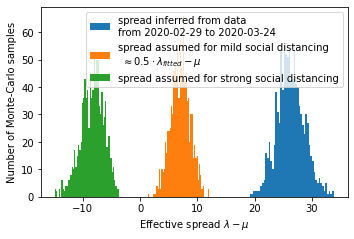

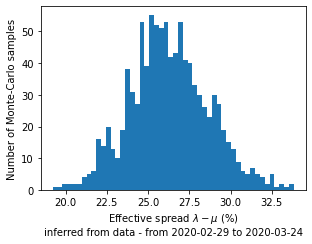

In [0]:
import matplotlib
#from google.colab import drive
#drive.mount('/content/gdrive')
#-------------------------------------------------------------------------------------------
#Step 5 Find the differential equation for the infected reduces to a simple linear equation
#       dI/dt = (λ-μ)*I
#-------------------------------------------------------------------------------------------
I = 100
dI_dt= (trace.λ - trace.μ)*I
dI_mild_dt = (np.maximum(trace.λ*(1-reduc_factor_mild) ,0) - trace.μ)*I
dI_strong_dt=(np.maximum(trace.λ*(1-reduc_factor_strong),0) - trace.μ)*I
#initial day
day_begin = date_data_end - datetime.timedelta(days = num_days)#t0 = t-delta_t
#-------------------------------------------------------------------------------
#Step 5.1 plotting data of Monte-Carlo samples
#-------------------------------------------------------------------------------
plt.figure(figsize=(5.5,3.5))
bins = np.linspace(-0.15, 0.38, 200)
plt.hist(dI_dt, bins=50, label='spread inferred from data\nfrom {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.hist(dI_mild_dt, bins=50, label='spread assumed for mild social distancing\n $\\approx 0.5 \\cdot \\lambda_{fitted} - \mu $')
plt.hist(dI_strong_dt, bins=50,label='spread assumed for strong social distancing')
plt.xlabel('Effective spread $\lambda - \mu$')
plt.ylabel('Number of Monte-Carlo samples')
plt.legend()
plt.savefig('Distributions_of_m.png', dpi=200)
#-------------------------------------------------------------------------------
#Step 5.2 plotting data of Monte-Carlo samples at spread inferred
#-------------------------------------------------------------------------------
plt.figure(figsize=(4.5,3.5))
bins = np.linspace(-0.11, 0.304, 200)
plt.hist(dI_dt, bins=50)
plt.xlabel('Effective spread $\lambda - \mu$ (%)\ninferred from data - from {} to {}'.format(day_begin.isoformat(), date_data_end.isoformat()))
plt.ylabel('Number of Monte-Carlo samples')
plt.tight_layout()
plt.savefig('Distributions_of_fitted_m.png', dpi=200)#save data in png file


# Scenarios 
![](https://drive.google.com/uc?id=1B2lkAAYip1-mMg3zRHonOJyjzLF0Pgzo)

In addition to the above constraints, we add explicit prior distributions for additional parameters that are (so far) only considered for the extrapolation beyond the observed measurement. This includes a delay between infection and report **D∼LogNormal(log(8),0.1)** assuming a median delay of 8 days.
With these priors, we now extrapolate the fitted model into three potential future scenarios. The scenarios are implemented by introducing a time-dependent spreading rate λt with :

* Everything stays the same and the spread continues with the inferred rate λt=λ.
* Mild social distancing: We assume λt gets reduced down to 50%, linearly within 7 days.
* Strong social distancing: We assume that λt gets reduced down to 10%, linearly within 7 days.

**Note that**, for each realization of the model, a different set of parameters (including λ0) is drawn from the posterior distribtion p(θ|a^) that was determined by the MCMC approach.

effective m: 1.261 +- 0.024


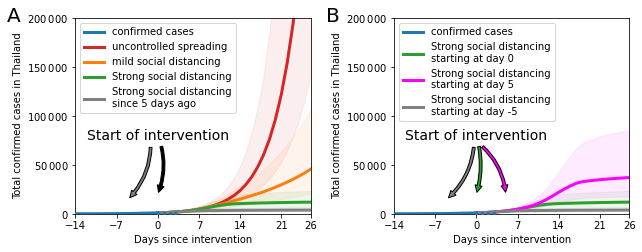

In [0]:
#-------------------------------------------------------------------------------
# Step 6 Plot Total confirm case 
#-------------------------------------------------------------------------------
#Labels
legends_lang = {
       "english": [
        # bottom left
        "confirmed cases",
        [
            "uncontrolled spreading",
            "mild social distancing",
            "Strong social distancing",
            "Strong social distancing\nsince 5 days ago",
        ],
        "Days since intervention",
        "Total confirmed cases in Thailand",
        "Start of intervention",
        # bottom right
        'confirmed cases',['Strong social distancing\nstarting at day 0', 
                           'Strong social distancing\nstarting at day 5',
                           "Strong social distancing\nstarting at day -5"],
        'Days since intervention',
        'Total confirmed cases in Thailand',
        'Start of intervention',
    ],
}
obs_cases_labels = ['new_I_no_change', 'new_I_soc_dist', 
                    'new_I_isol', 'new_I_isol_later', 'new_I_isol_earlyier']
#formate date
date_today_formatted = '{}/{}/{}'.format(date_today.month, date_today.day, str(date_today.year)[2:4])
#past and present plot data
cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Thailand', '1/22/20':date_today_formatted])[0]
#future plot data
cases_obs_to_plot_future = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'Thailand', date_today_formatted:])[0]

# Observe case future
def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_I_past, axis=1)[:, None] + trace.I_begin[:, None]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)
#plotting data of figure A
for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[9, 3.6])
    # bottom left
    colors = ["tab:red", "tab:orange", "tab:green", "gray"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[0]
    # time arangement for plot
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue',zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0,num_days_to_predict)
        cases = dict_obsc_cases[label]
        #find median
        median = np.median(cases, axis=-1)
        percentiles = (np.percentile(cases, q=2.5, axis=-1),
                       np.percentile(cases, q=97.5, axis=-1),
                      )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)
    
    ax.set_xlim(-14, 26)
    ax.set_ylim(0, 200_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21,26])
    ax.locator_params(nbins=4, axis="y")
    #function format
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.text(-0.29, 0.98, "A", transform=ax.transAxes, size=20)
    #drqw black arrow
    ax.annotate(
        legends_list[4],
        xy=(0.0, 20_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc="black"),
    )
    #Draw gray arrow
    ax.annotate(
        "",
        xy=(-5.0, 15_000),
        xycoords="data",
        xytext=(0.32, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[3] ),
    )
    #plotting data of figure B
    # bottom right
    ax = axes[1]
    colors = ["tab:green", "fuchsia","gray"]
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue',zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)
    
    dict_obsc_cases = return_obs_cases_future(trace)
    #ax.plot([], [], alpha=0, label=legends_list[6][0])
    for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        median = np.median(cases, axis=-1)
        percentiles = (np.percentile(cases, q=2.5, axis=-1),
                       np.percentile(cases, q=97.5, axis=-1),
                      )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 26)
    ax.set_ylim(0, 200_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21,26])
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.text(-0.29, 0.98, "B", transform=ax.transAxes, size=20)
    #draw green arrow
    ax.annotate(
        legends_list[9],
        xy=(0.0, 20_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]),
    )
    #draw pink arrow
    ax.annotate(
        "",
        xy=(5.0, 20_000),
        xycoords="data",
        xytext=(0.37, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]),
    )
    #draw gray arrow
    ax.annotate(
        "",
        xy=(-5.0, 15_000),
        xycoords="data",
        xytext=(0.34, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]),
    )
    # wrapping up
    fig.subplots_adjust(hspace=-0.50)
    fig.tight_layout()
    fig.savefig(path_to_save + "cumulative_corona_thailand_combined_{}.png".format(lang), dpi=300)# save image

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))

We developed a SIR model to sketch three different future scenarios (Figure), starting from the 1st of March 2020:


1. If we continue as before, the growth rate remains at around 30% per day (red curve).


2. If we partially restrict our contacts (orange curve) and only meet about half as many people, then the exponential growth will slow down and we gain some time.


3. If we introduce much stricter measures for all people, then the curve may flatten out (green) - only few new cases occur.


![alt text](https://drive.google.com/uc?id=1Pe3TMm4pTVU36Oe1B4XvNBsMZFCt4HD4)


**Figure A:** We modeled three different future scenarios and a past model for the development of confirmed COVID-19 cases in Thailand: unchanged spread, mild restriction of contacts, or strict restriction of contacts.


**Figure B:**  We also analyzed how a delayed restriction impacts case numbers: Strict restrictions starting on day zero, or five days later can make a substatial difference in case numbers. A delay of five days in implementing restrictions has a major impact on the expected case numbers.

**Model assumptions:** The forecasts are based on the SIR model. **Figure A, red:** The infection rate is unaltered. **Figure A, orange:** The infection rate (which scales as a function of the number of contacts per person) is cut in half. **Figure A, green:** The infection rate is reduced to 1/10th. Shaded areas indicate the variability in the prediction (95 % confidence interval). 

**The evolution of the total number of cases**, it can be seen very clearly that a change in behavior will only be visible in 7-10 days. Only on day 7, the curves start to show a difference from each other. This is because many people are already infected, but they have not yet been identified and tested. Due to this uncertainty, it is especially important to reduce the number of contacts for everyone. If we wait another 5 days, the number of cases will increase threefold, even in the best scenario **(Figure B).**